In [1]:
from diffsynth import ModelManager, KolorsImagePipeline
from peft import LoraConfig, inject_adapter_in_model
import torch

In [2]:
def load_lora(model, lora_rank, lora_alpha, lora_path):
    lora_config = LoraConfig(
        r=lora_rank,
        lora_alpha=lora_alpha,
        init_lora_weights="gaussian",
        target_modules=["to_q", "to_k", "to_v", "to_out"],
    )
    model = inject_adapter_in_model(lora_config, model)
    state_dict = torch.load(lora_path, map_location="cpu")
    model.load_state_dict(state_dict, strict=False)
    return model

In [3]:
# Load models
model_manager = ModelManager(torch_dtype=torch.float16, device="cuda",
                             file_path_list=[
                                 "/data/models/kolors/Kolors/text_encoder",
                                 "/data/models/kolors/Kolors/unet/diffusion_pytorch_model.safetensors",
                                 "/data/models/kolors/Kolors/vae/diffusion_pytorch_model.safetensors"
                             ])
pipe = KolorsImagePipeline.from_model_manager(model_manager)

# Generate an image with lora
pipe.unet = load_lora(
    pipe.unet,
    lora_rank=4, lora_alpha=4.0, # The two parameters should be consistent with those in your training script.
    lora_path="/root/autodl-fs/models/lml_lora/lightning_logs/version_0/checkpoints/epoch=0-step=500.ckpt" #"/root/autodl-fs/models/kolors_lora/lightning_logs/version_0/checkpoints/epoch=5-step=3000.ckpt"
)
# torch.manual_seed(0)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


100%|██████████| 50/50 [00:08<00:00,  5.85it/s]


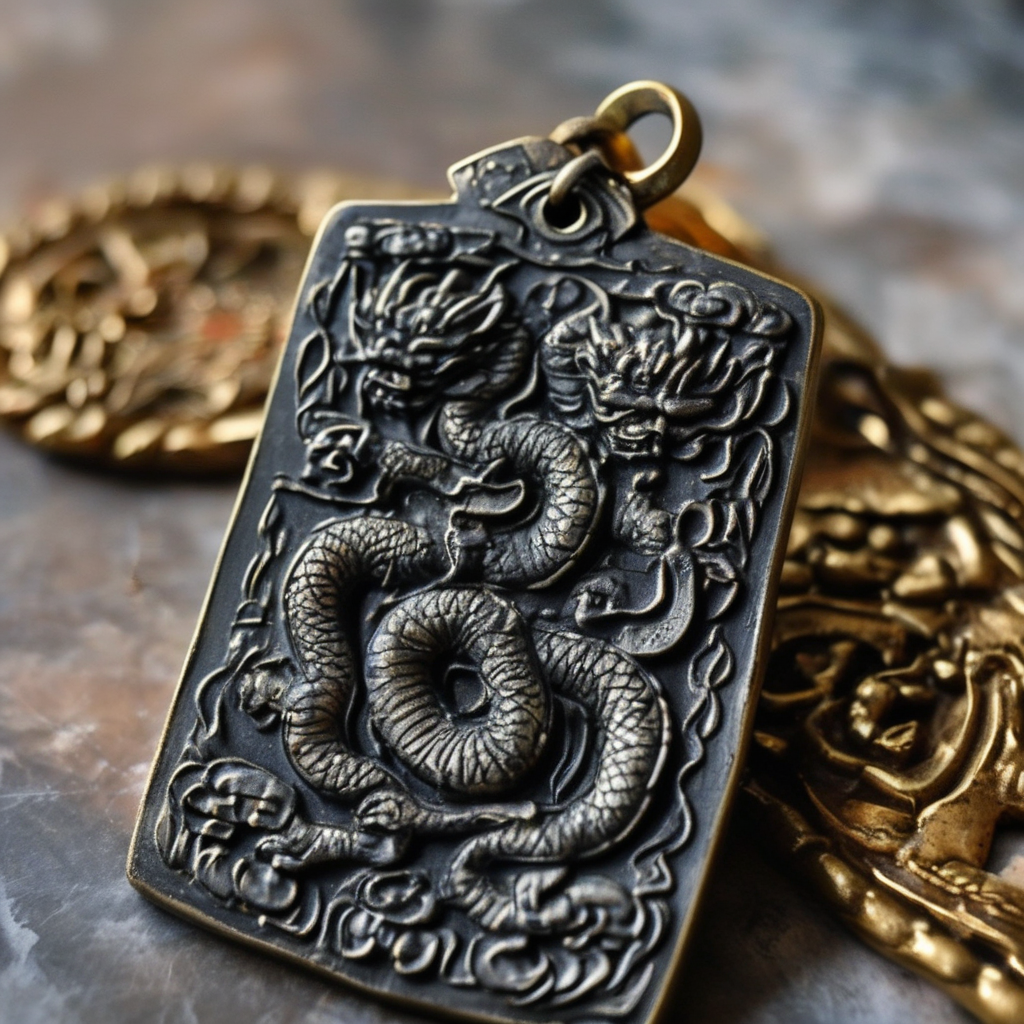

In [6]:

image = pipe(
    prompt="左边放着一枚免死金牌",
    negative_prompt="",
    cfg_scale=2,
    num_inference_steps=50, height=1024, width=1024,
).show()
